In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import itertools
import pprint

import orbax.checkpoint
import jax
import jax.numpy as jnp
import torch.utils.data.dataloader
import tensorflow as tf
import sqlalchemy as sa
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, flow_matching, utils, main as main_module

2025-01-13 03:20:45.635720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736738445.653553   40664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736738445.659107   40664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
engine = cs.get_engine()
cs.create_all(engine)
session = cs.orm.Session(engine)
session.begin()

In [4]:
config_alt_ids = {
    # Lorenz
    'fyralbgq': 'VE-SDE',
    'ydboviga': 'Flow Matching',

    # Simple Harmonic Oscillator
    # 'llqlijqb',
    # 'ephiczel',
}

In [5]:
cfgs = session.execute(sa.select(cs.Config).where(cs.Config.alt_id.in_(config_alt_ids)))
cfgs = [c for (c,) in cfgs]
reference_cfg = cfgs[0]

In [6]:
key = jax.random.key(reference_cfg.rng_seed)

In [7]:
key, key_dataset = jax.random.split(key)
ds = datasets.get_dataset(reference_cfg.dataset, key=key_dataset)
splits = datasets.split_dataset(reference_cfg.dataset, ds)
dataloaders = {}
for n, s in splits.items():
    dataloaders[n] = torch.utils.data.dataloader.DataLoader(
        list(tf.data.Dataset.from_tensor_slices(s).batch(reference_cfg.dataset.batch_size).as_numpy_iterator()),
        batch_size=1,
        collate_fn=lambda x: x[0],
    )
data_std = splits['train'].std()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 12.04it/s]
I0000 00:00:1736738496.069765   40664 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4247 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6


In [8]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
x_sample = next(iter(dataloaders['train']))

cfg_info = {}
for cfg in cfgs:
    assert cfg.rng_seed == reference_cfg.rng_seed
    assert cfg.dataset == reference_cfg.dataset

    cfg_unet = unet.unet_64_config(
        splits['train'].shape[-1],
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    # just create params, restore saved weights later
    params = model.init(
        jax.random.key(0),
        x=jnp.ones(x_sample.shape),
        t=jnp.ones(x_sample.shape[0]),
        train=False,
        cond=main_module.condition_on_initial_time_steps(x_sample, cfg.dataset.time_step_count_conditioning),
    )
    ema_params = orbax_checkpointer.restore(cfg.run_dir/'last_ema')

    if isinstance(cfg.model, cs.ModelDiffusion):
        jax_lightning = diffusion.JaxLightning(cfg, jax.random.key(0), dataloaders, data_std, None, model)
    elif isinstance(cfg.model, cs.ModelFlowMatching):
        jax_lightning = flow_matching.JaxLightning(cfg, jax.random.key(0), dataloaders, data_std, None, model)
    else:
        raise ValueError(f'Unknown model: {cfg.model}')

    cfg_info[cfg.alt_id] = dict(
        cfg=cfg,
        jax_lightning=jax_lightning,
        ema_params=ema_params,
    )

/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [9]:
# evaluation_trajectories = ds.Zs[reference_cfg.dataset.batch_size:][:reference_cfg.dataset.batch_size]
evaluation_trajectories = next(iter(dataloaders['val']))

In [10]:
cond = main_module.condition_on_initial_time_steps(evaluation_trajectories, reference_cfg.dataset.time_step_count_conditioning)
trajectory_count = reference_cfg.dataset.batch_size
for config_alt_id, info in cfg_info.items():
    cfg = info['cfg']
    key, key_samples = jax.random.split(key)
    if isinstance(cfg.model, cs.ModelDiffusion):
        def score(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return info['jax_lightning'].score(x, t, cond, info['ema_params'])
            
        samples = samplers.sde_sample(info['jax_lightning'].diffusion, score, key_samples, x_shape=x_sample.shape, nsteps=cfg.model.sde_time_steps)
        info['samples'] = samples
    elif isinstance(cfg.model, cs.ModelFlowMatching):
        def velocity(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return info['jax_lightning'].velocity(x, t, cond, info['ema_params'])
        
        samples = flow_matching.heun_sample(key_samples, 1., velocity, x_shape=x_sample.shape, nsteps=cfg.model.ode_time_steps)
        info['samples'] = samples
    else:
        raise ValueError(f'Unknown model: {cfg.model}')

In [11]:
for info in cfg_info.values():
    info['relative_error'] = utils.relative_error(evaluation_trajectories, info['samples'])

In [12]:
info['relative_error'].shape

(500, 60)

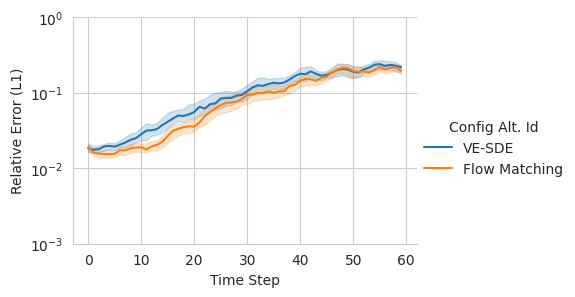

In [13]:
for info in cfg_info.values():
    df = (
        pd.DataFrame(info['relative_error'])
        .melt(var_name='Time Step', value_name='Relative Error (L1)')
    )
    info['relative_error_df'] = df
df = pd.concat([
    info['relative_error_df']
    for info in cfg_info.values()
], keys=map(config_alt_ids.get, cfg_info), names=['Config Alt. Id']).reset_index('Config Alt. Id')
sns.relplot(
    kind='line',
    estimator='median',
    data=df,
    x='Time Step',
    y='Relative Error (L1)',
    hue='Config Alt. Id',
    height=3,
    aspect=1.5,
).set(
    yscale='log',
    ylim=(1e-3, 1),
)

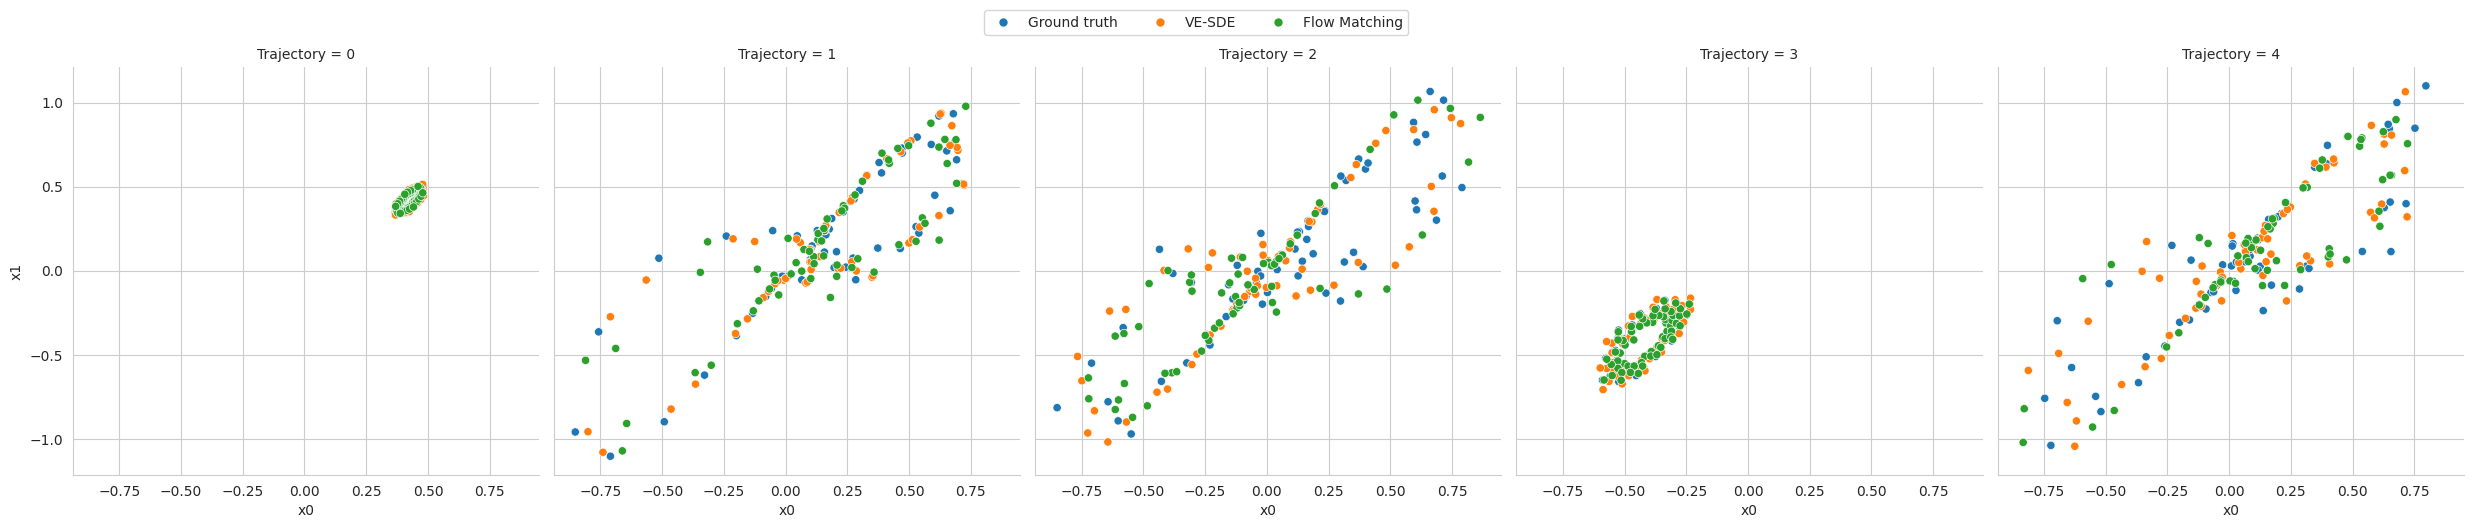

In [14]:
trajectory_count = 5
df = pd.concat([
    *[
        pd.DataFrame(dict(
            Source='Ground truth', Trajectory=str(i), x0=evaluation_trajectories[i, :, 0], x1=evaluation_trajectories[i, :, 1]
        ))
        for i in range(trajectory_count)
    ],
    *itertools.chain.from_iterable([
            [
                pd.DataFrame(dict(
                    Source=config_alt_ids[config_alt_id], Trajectory=str(i), x0=info['samples'][i, :, 0], x1=info['samples'][i, :, 1]
                ))
                for i in range(trajectory_count)
            ]
        for config_alt_id, info in cfg_info.items()
    ])
]).reset_index(names=['Time Step'])
share_axes = True
center_axes = False
plot = sns.relplot(
    data=df,
    x='x0', y='x1',
    hue='Source',
    col='Trajectory',
    facet_kws=dict(
        sharex=share_axes,
        sharey=share_axes,
    )
)
xmax, ymax = df[['x0', 'x1']].max(axis=0) + .4
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    if not share_axes:
        xmax, ymax = data[['x0', 'x1']].max(axis=0) + .4
    if center_axes:
        ax.set_xlim(xmin=-xmax, xmax=xmax)
        ax.set_ylim(ymin=-ymax, ymax=ymax)
        ax.set_aspect('equal')
        ax.plot([0], [0], 'kx')
sns.move_legend(
    plot,
    loc='upper center',
    ncol=len(cfg_info) + 1,
    title='',
    # labels=[],
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

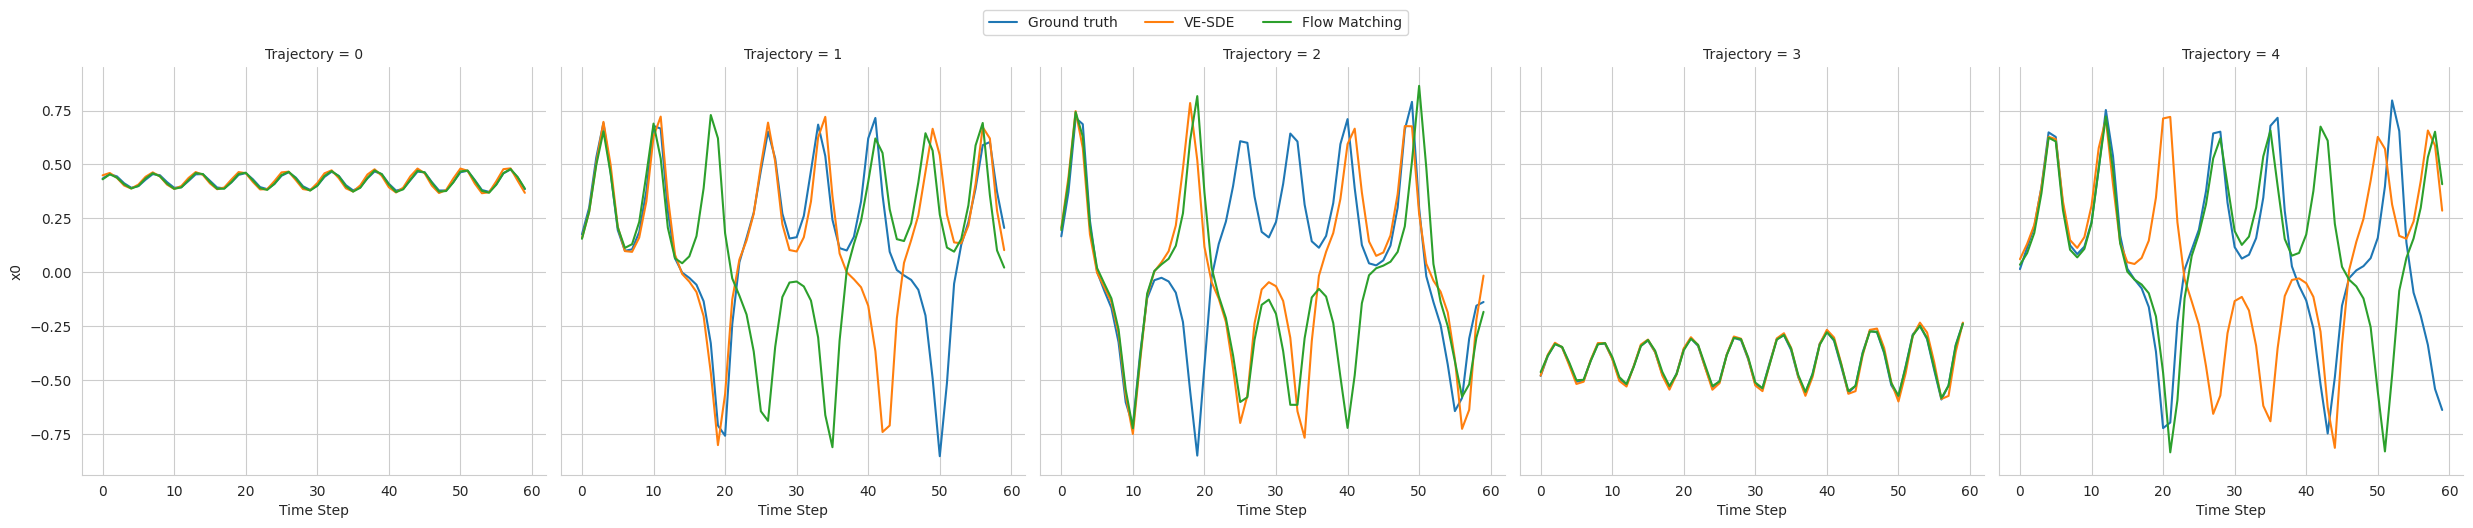

In [15]:
plot = sns.relplot(
    kind='line',
    data=df,
    x='Time Step',
    y='x0',
    hue='Source',
    col='Trajectory'
)
sns.move_legend(
    plot,
    loc='upper center',
    ncol=len(cfg_info) + 1,
    title='',
    # labels=[],
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

In [16]:
# session.close()